# 06. Model Selection

### Importando as bibliotecas

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions.fn_stats as fn_stats
import functions.fn_charts as fn_charts
import params.consts as consts
from sklearn.preprocessing import (OneHotEncoder, MinMaxScaler, PowerTransformer,)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_validate

### Lendo o dataset tratado e visualizando o overview atual

In [2]:
df = pd.read_csv(consts.DATASET_LEAN) # Armazenando o dataset tratado em uma variável

In [3]:
df # Exbindo uma visão geral do dataset

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1,2,2,Real Bed,270.0,51.0,4,t,f,strict,2018,4
1,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1,1,2,Real Bed,161.0,45.0,4,f,f,strict,2018,4
2,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1,1,2,Real Bed,222.0,68.0,2,t,f,strict,2018,4
3,t,1.0,-22.988165,-43.193588,Apartment,Entire home/apt,3,1,1,2,Real Bed,308.0,86.0,2,f,f,strict,2018,4
4,t,1.0,-22.981269,-43.190457,Loft,Entire home/apt,2,1,1,2,Real Bed,219.0,80.0,3,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581978,f,1.0,-22.986030,-43.191660,Apartment,Entire home/apt,4,2,2,3,Real Bed,250.0,0.0,1,f,f,flexible,2019,9
581979,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1,0,2,Real Bed,121.0,50.0,1,f,f,flexible,2019,9
581980,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2,2,3,Real Bed,799.0,0.0,2,f,f,flexible,2019,9
581981,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1,1,1,Real Bed,250.0,0.0,1,f,f,strict_14_with_grace_period,2019,9


In [4]:
df.shape # Visualizando a quantidade de linhas e colunas do dataset

(581983, 19)

In [5]:
df.info() # Exibindo as informações das variáveis do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581983 entries, 0 to 581982
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         581983 non-null  object 
 1   host_listings_count       581983 non-null  float64
 2   latitude                  581983 non-null  float64
 3   longitude                 581983 non-null  float64
 4   property_type             581983 non-null  object 
 5   room_type                 581983 non-null  object 
 6   accommodates              581983 non-null  int64  
 7   bathrooms                 581983 non-null  int64  
 8   bedrooms                  581983 non-null  int64  
 9   beds                      581983 non-null  int64  
 10  bed_type                  581983 non-null  object 
 11  price                     581983 non-null  float64
 12  extra_people              581983 non-null  float64
 13  minimum_nights            581983 non-null  i

In [6]:
fn_stats.describe(df) # Usando a função que exibe as estatísticas das colunas numéricas

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,minimum_nights,ano,mes
count,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00,581983.00
mean,1.71,-22.96,-43.25,3.47,1.36,1.36,2.10,319.63,22.38,2.55,2018.85,6.34
std,1.22,0.04,0.10,1.63,0.58,0.73,1.23,262.00,33.89,1.64,0.72,3.40
min,0.00,-23.07,-43.72,1.00,0.00,0.00,0.00,0.00,0.00,1.00,2018.00,1.00
25%,1.00,-22.98,-43.30,2.00,1.00,1.00,1.00,138.00,0.00,1.00,2018.00,4.00
50%,1.00,-22.97,-43.20,3.00,1.00,1.00,2.00,228.00,0.00,2.00,2019.00,6.00
75%,2.00,-22.94,-43.19,4.00,2.00,2.00,3.00,401.00,50.00,3.00,2019.00,9.00
max,6.00,-22.75,-43.10,9.00,3.00,3.00,6.00,1276.00,125.00,8.00,2020.00,12.00


In [7]:
df.describe(exclude='number') # Exibindo as estatísticas das colunas categóricas

,host_is_superhost,property_type,room_type,bed_type,instant_bookable,is_business_travel_ready,cancellation_policy
count,581983,581983,581983,581983,581983,581983,581983
unique,2,12,4,2,2,1,4
top,f,Apartment,Entire home/apt,Real Bed,f,f,flexible
freq,519412,458354,372443,570643,352395,581983,258096


In [8]:
df.isnull().sum() # Somando todos os valores nulos de cada coluna

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
price                       0
extra_people                0
minimum_nights              0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64

### Definindo os valores de x e y para o modelo de classificação

In [9]:
x = df.drop('price', axis=1) # Definindo os valores de x para o modelo, separando a variável target do dataset
y = df['price'] # Definindo os valores de y para o modelo, deixando o dataset somente com a variável target

In [10]:
x.head(3) # Visualizando os dados de x

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1,2,2,Real Bed,51.0,4,t,f,strict,2018,4
1,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1,1,2,Real Bed,45.0,4,f,f,strict,2018,4
2,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1,1,2,Real Bed,68.0,2,t,f,strict,2018,4


In [11]:
y.head(3) # Visualizando os dados de y

0    270.0
1    161.0
2    222.0
Name: price, dtype: float64

### Listando as variáveis numéricas e categóricas de x

In [12]:
numerical_features = x.select_dtypes(include='number').columns # Armazenando as features numéricas em uma variável
categorical_features = x.select_dtypes(exclude='number').columns # Armazenando as features categóricas em uma variável

print('- Numerical Features:') # Printando as variávei numéricas
for feature in numerical_features:
    print(feature)

print('\n- Categorical Features:') # Printando as variávei categóricas
for feature in categorical_features:
    print(feature)

- Numerical Features:
host_listings_count
latitude
longitude
accommodates
bathrooms
bedrooms
beds
extra_people
minimum_nights
ano
mes

- Categorical Features:
host_is_superhost
property_type
room_type
bed_type
instant_bookable
is_business_travel_ready
cancellation_policy


### Visualizando a distribuição das features de x em histogramas

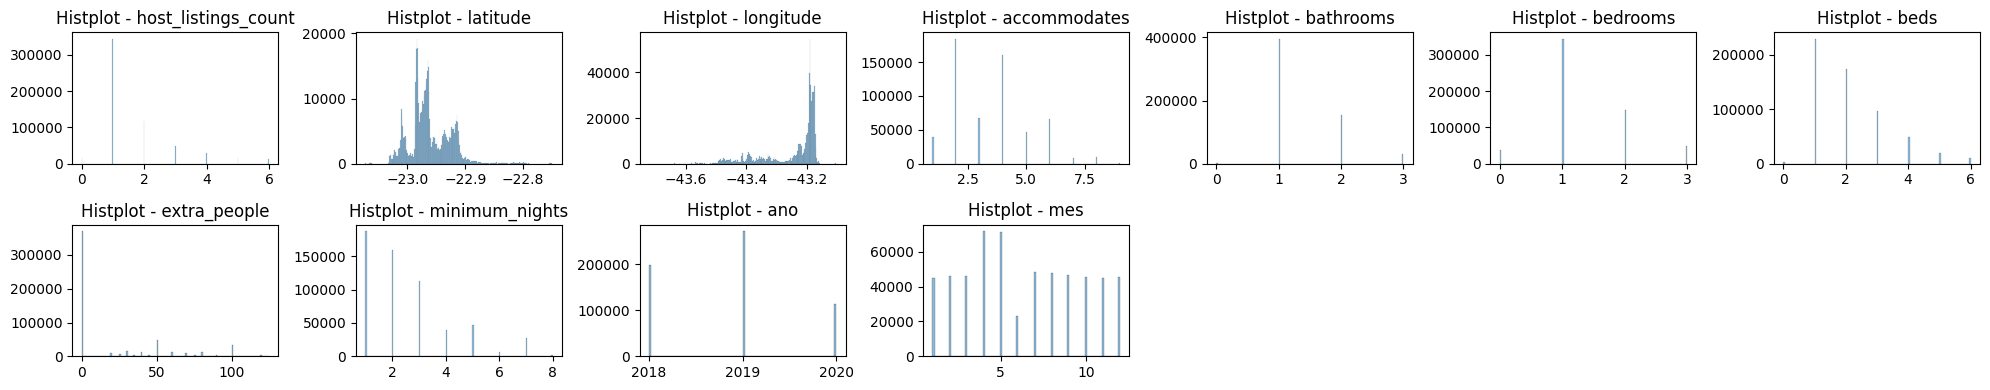

In [13]:
fn_charts.histplots(x, numerical_features, num_cols=7, height_figsize=2) # Criando os histplots para ver sua distribuição

### Definindo por qual procedimento cada feature de x vai passar

In [14]:
one_hot_cols = [ # Definindo as colunas que vão passar por One Hot Encoder
    'host_is_superhost', # Coluna categórica
    'property_type', # Coluna categórica
    'room_type', # Coluna categórica
    'bed_type', # Coluna categórica
    'instant_bookable', # Coluna categórica
    'is_business_travel_ready', # Coluna categórica
    'cancellation_policy', # Coluna categórica
    'host_listings_count', # Coluna com inteiros discretos
    'accommodates', # Coluna com inteiros discretos
    'bathrooms', # Coluna com inteiros discretos
    'bedrooms', # Coluna com inteiros discretos
    'beds', # Coluna com inteiros discretos
    'minimum_nights', # Coluna com inteiros discretos
]

power_cols = [ # Definindo as colunas que vão passar por Power Transformation
   'extra_people', # Coluna com assimetria dos dados
   'latitude', # Coluna com assimetria dos dados
   'longitude', # Coluna com assimetria dos dados
]

min_max_cols = [ # Definindo as colunas que vão passar por Min-Max Scaler
    'ano', # Coluna com distribuição uniforme dos dados
    'mes', # Coluna com distribuição uniforme dos dados
]

### Definindo os modelos de classificação que serão usados

In [15]:
models = { # Definindo os modelos de regressão que serão usados
    # 'DummyRegressor': DummyRegressor(strategy='mean'),  # Modelo base para referência
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=consts.RANDOM_STATE),
    # 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    # 'RandomForestRegressor': RandomForestRegressor(random_state=consts.RANDOM_STATE),
    # 'ExtraTreesRegressor': ExtraTreesRegressor(random_state=consts.RANDOM_STATE),
}

# Usando apenas alguns modelos pois como a base é extremamente grande e ainda está sendo feito o cross validation, está demorando muito
# tempo para treinar os modelos

### Criando a função com o pipeline

In [16]:
def pipeline( # Função para fazer todo o procedimento de pipeline e validação cruzada, e retornar os scores
    x, # Passando o x como parâmetro da função
    y, # Passando o y como parâmetro da função
    model, # Passando o modelo como parâmetro da função
): 

    preprocessing = ColumnTransformer( # Estabelecendo os pré processamentos que serão aplicados nas features
        [ # Passando a inicial do novo nome da coluna, o pré processamento que será aplicado e a lista de colunas para pré processamento
            ('one_hot', OneHotEncoder(), one_hot_cols),
            ('min_max', MinMaxScaler(), min_max_cols),
            ('power', PowerTransformer(), power_cols),
        ]
    )

    pipeline = Pipeline( # Criando o pipeline para o modelo de classificação (Pipeline do Imblearn para tratar o desbalanceamento do dataset)
        [ # Passando as etapas do pipeline
            ('pre_processing', preprocessing), # Fazendo o pré processamento conforme as definições anteriores
            ('models', model), # Aplicando o modelo passado para a função
        ]
    )

    scores = cross_validate( # Fazendo a validação cruzada para testar diversas combinações de separação entre dados de treino e teste
            # visando ter diversos valores para as métricas, e assim trabalhar com os valores médios ou mais frequentes
        pipeline, # Passando o pipeline definido acima
        x, # Passando o dataset x
        y, # Passando o dataset y
        cv=KFold(n_splits=2, shuffle=True, random_state=consts.RANDOM_STATE), # Aplicando o StratifiedKFold por ser um dataset 
            # desbalanceado, com um número inicial de 5 folds e aplicando o shuffle pois não se trata de um caso de séries temporais
        scoring=['r2', 'neg_root_mean_squared_error'], # Definindo as métricas de avaliação dos modelos
        n_jobs=-2, # Definindo para usar toda a capacidade de processamento do computador e deixar um processador livre para não travar
    )

    return scores # Retornando os scores

### Aplicando a função com o pipeline e armazenando os resultados de cada modelo

In [17]:
results = { # Aplicando a função com o Pipeline, passando os datasets x, y e os modelos, e armazenando os resultados em uma variável
    # 'DummyRegressor': pipeline(x, y, models['DummyRegressor']), # 10 seg
    'LinearRegression': pipeline(x, y, models['LinearRegression']), # 1 min
    'DecisionTreeRegressor': pipeline(x, y, models['DecisionTreeRegressor']), # 5 min
    # 'KNeighborsRegressor': pipeline(x, y, models['KNeighborsRegressor']),
    # 'RandomForestRegressor': pipeline(x, y, models['RandomForestRegressor']),
    # 'ExtraTreesRegressor': pipeline(x, y, models['ExtraTreesRegressor']),
}

# Usando apenas alguns modelos pois como a base é extremamente grande e ainda está sendo feito o cross validation, está demorando muito
# tempo para treinar os modelos

### Criando um dataset com os resultados dos modelos

In [18]:
for key, value in results.items(): # Criando uma estrutura de repetição para percorrer os resultados dos modelos
    results[key]['time'] = results[key]['fit_time'] + results[key]['score_time'] # Criando a coluna de tempo somando fit_time e score_time

df_results = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'model'}) # Criando um df transposto com os resultados dos modelos

df_results_explode = df_results.explode(df_results.columns[1:].to_list()).reset_index(drop=True) # Criando um df separando os maps por linhas

df_results_explode['test_neg_root_mean_squared_error'] = df_results_explode['test_neg_root_mean_squared_error'] * -1 # Transformando em positivo

df_results_explode # Exibindo o dataset com os resultados dos modelos

,model,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,time
0,LinearRegression,10.972163,2.441308,0.359024,209.935802,13.413471
1,LinearRegression,10.281369,1.965496,0.358727,209.629462,12.246865
2,DecisionTreeRegressor,335.434502,1.200289,0.90839,79.366401,336.634791
3,DecisionTreeRegressor,336.4547,1.144519,0.909981,78.541442,337.599219


### Comparando os resultados dos modelos através de boxplots

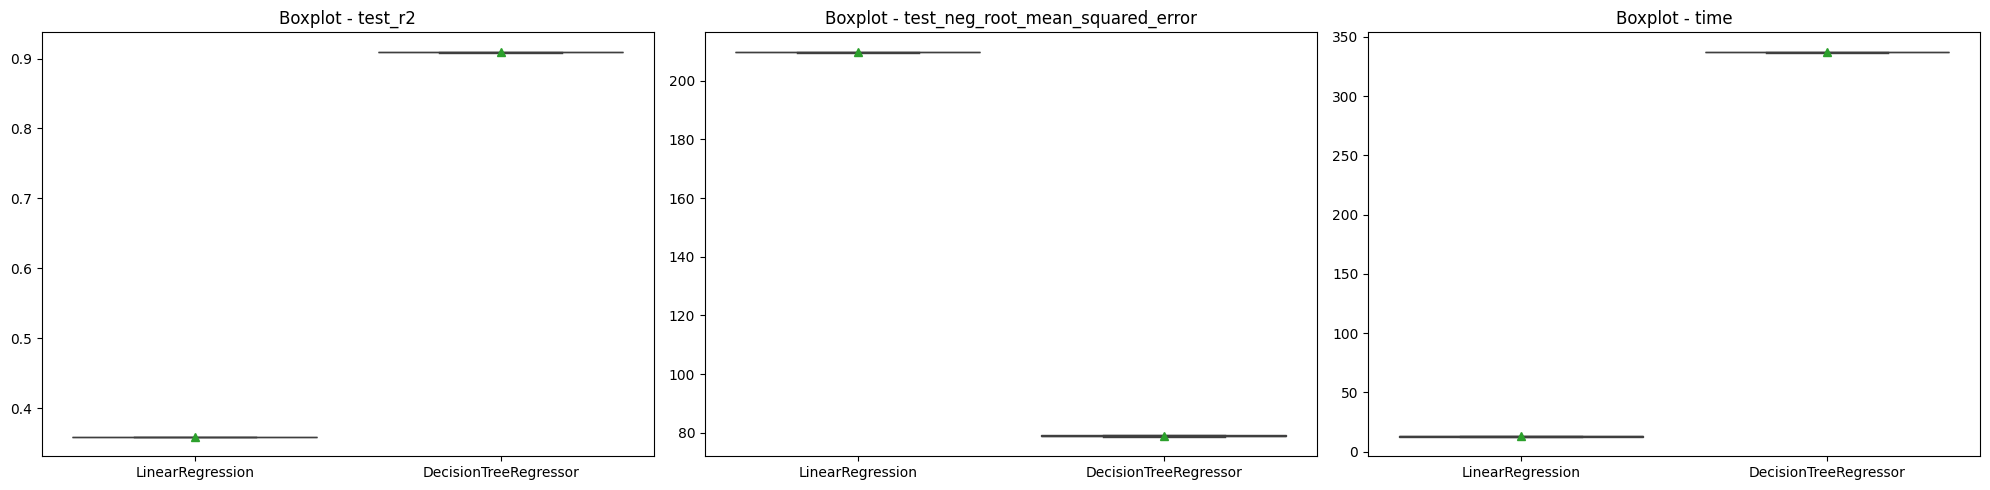

In [19]:
fn_charts.boxplots(df_results_explode, df_results.columns[3:].to_list(), 'model') # Criando os boxplots para avaliação dos modelos

### Avaliando os resultados de cada modelo

| Posição    | Accuracy              | Precision             | Recall                | ROC_AUC               | Average Precision     | Time                  |
|------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|
| Referência | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto maior melhor    | Quanto menor melhor    |
| 1          | **LogisticRegression**     | **LogisticRegression**     | KNNClassifier          | **LogisticRegression**     | **LogisticRegression**     | **LogisticRegression**     |
| 2          | KNNClassifier          | KNNClassifier          | **LogisticRegression**     | KNNClassifier          | KNNClassifier          | DummyClassifier        |
| 3          | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier | DecisionTreeClassifier |
| 4          | DummyClassifier        | DummyClassifier        | DummyClassifier        | DummyClassifier        | DummyClassifier        | KNNClassifier          |

### Definindo o modelo que será utilizado no projeto de classificação

Após análise dos resultados de cada um dos modelos, é possível concluir que o modelo com os melhores resultados foi o de Logistic Regression, pois liderou os resultados nas métricas de Accuracy, Precision, ROC_AUC, Average Precision e Time, e ficou na segunda posição na métrica de Recall. Além disso, no caso de datasets desbalanceados como é o caso desse estudo, as principais métricas avaliadas são o ROC_AUC e o Average Precision, onde o modelo de Logistic Regression também obteve as melhores performances. E em relação ao processamento, esse modelo também teve a melhor performance com o menor tempo de processamento. 

Portando, diante de todo esse contexto, **o melhor modelo para ser usado no projeto é o Logistic Regression**.